# Histopathological Cancer Detection

**Team Name**: not-awesome-aardvark

This task utilizes the Kaggle Histopathological Cancer Detection dataset from: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

For all of our project source codes, please refer to https://drive.google.com/drive/folders/1Y8TF6ItZKtItMg5mCOGMd-aSq1U_sHmw?usp=share_link.

# Data Exploration

## Data Preparation

Assuming that the dataset is already uploaded to google drive, we need to first mount and unzip them into colab.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
# !unzip "/content/gdrive/Shareddrives/CIS520/dataset/train_cropped.zip" -d "/content"
# !unzip "/content/gdrive/Shareddrives/CIS520/dataset/histopathologic-cancer-detection.zip" -d "/content"

## Data Visualization

Import necessary packages and define necessary file/directory paths here for data visualization

In [ ]:
# imports
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

# set seeds
torch.manual_seed(1)
random.seed(1)

# define paths
TRAIN_DIR = "/content/train"
TRAIN_CROPPED_DIR = "/content/train_cropped"
CSV_PATH_0 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class0_5.csv'
CSV_PATH_1 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class1_5.csv'
TEST_CSV_PATH = '/content/gdrive/Shareddrives/CIS520/dataSupersets/test_ImagesAndLabels.csv'

Display sample size and class ratio for the raw dataset

Length of the raw dataset: 220025
Number of label-0 images:  130908
Number of label-1 images:  89117


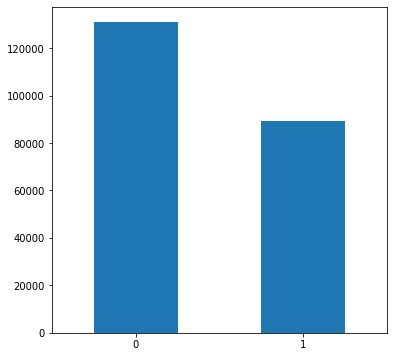

In [ ]:
df_raw = pd.read_csv('/content/train_labels.csv')
counts = df_raw['label'].value_counts()
print(f'Length of the raw dataset: {len(df_raw)}')
print(f'Number of label-0 images:  {counts[0]}')
print(f'Number of label-1 images:  {counts[1]}')
plt.rcParams["figure.figsize"] = (6,6)
counts.plot(kind='bar', rot=0)

As shown in the figure above, there is a class imbalance between label-0 and label-1 in the raw dataset of roughly 0.6:0.4.

However, we will not use the raw dataset. Instead, we take 6 perfectly-balanced subsets as our training data.

Display sample size and class ratio for the training subsets that we will actually use throughout this project

In [ ]:
CSV_PATH_0_3 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class0_5.csv'
CSV_PATH_1_3 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class1_5.csv'
CSV_PATH_0_4 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class0_10.csv'
CSV_PATH_1_4 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class1_10.csv'
CSV_PATH_0_5 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class0_25.csv'
CSV_PATH_1_5 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class1_25.csv'
CSV_PATH_0_6 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class0_50.csv'
CSV_PATH_1_6 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class1_50.csv'

In [ ]:
df1 = pd.concat([pd.read_csv(CSV_PATH_0_3).loc[:2000,:], pd.read_csv(CSV_PATH_1_3).loc[:2000,:]], axis=0).sample(frac=1).reset_index(drop=True)
df2 = pd.concat([pd.read_csv(CSV_PATH_0_3).loc[:3500,:], pd.read_csv(CSV_PATH_1_3).loc[:3500,:]], axis=0).sample(frac=1).reset_index(drop=True)
df3 = pd.concat([pd.read_csv(CSV_PATH_0_3), pd.read_csv(CSV_PATH_1_3)], axis=0).sample(frac=1).reset_index(drop=True)
df4 = pd.concat([pd.read_csv(CSV_PATH_0_4), pd.read_csv(CSV_PATH_1_4)], axis=0).sample(frac=1).reset_index(drop=True)
df5 = pd.concat([pd.read_csv(CSV_PATH_0_5), pd.read_csv(CSV_PATH_1_5)], axis=0).sample(frac=1).reset_index(drop=True)
df6 = pd.concat([pd.read_csv(CSV_PATH_0_6), pd.read_csv(CSV_PATH_1_6)], axis=0).sample(frac=1).reset_index(drop=True)

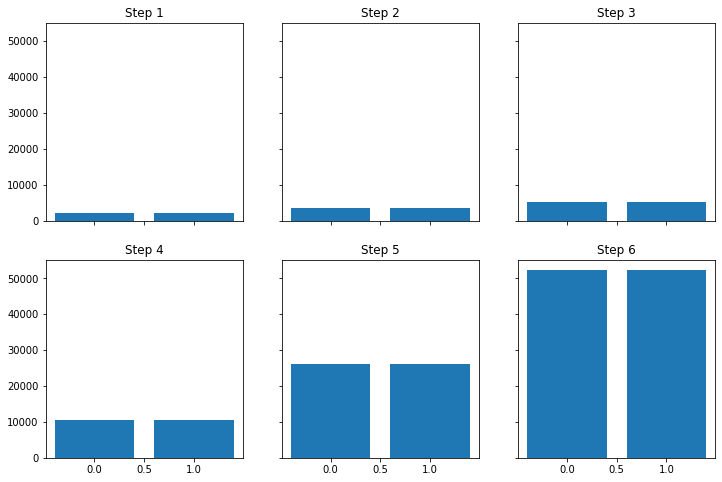

In [ ]:
plt.rcParams["figure.figsize"] = (12,8)
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='all', sharey='all')
axs[0, 0].bar(df1['label'].value_counts().index, df1['label'].value_counts().values)
axs[0, 0].set_title('Step 1')
axs[0, 1].bar(df2['label'].value_counts().index, df2['label'].value_counts().values)
axs[0, 1].set_title('Step 2')
axs[0, 2].bar(df3['label'].value_counts().index, df3['label'].value_counts().values)
axs[0, 2].set_title('Step 3')
axs[1, 0].bar(df4['label'].value_counts().index, df4['label'].value_counts().values)
axs[1, 0].set_title('Step 4')
axs[1, 1].bar(df5['label'].value_counts().index, df5['label'].value_counts().values)
axs[1, 1].set_title('Step 5')
axs[1, 2].bar(df6['label'].value_counts().index, df6['label'].value_counts().values)
axs[1, 2].set_title('Step 6')
plt.show()

As shown in the figure above, all 6 subsets that we will use for the project are perfectly class-balanced.

Display shape (feature size) of uncropped and cropped images

In [ ]:
img_name = df_raw.loc[random.randint(0,len(df_raw)),'id']+'.tif'
img_raw = Image.open(os.path.join(TRAIN_DIR, img_name))
img_cropped = Image.open(os.path.join(TRAIN_CROPPED_DIR, img_name))
print(f"Uncropped image feature size: {img_raw.size}")
print(f"Cropped image feature size:   {img_cropped.size}")

Uncropped image feature size: (96, 96)
Cropped image feature size:   (32, 32)


Display sample images for both uncropped (96x96x3) and cropped (32x32x3) versions

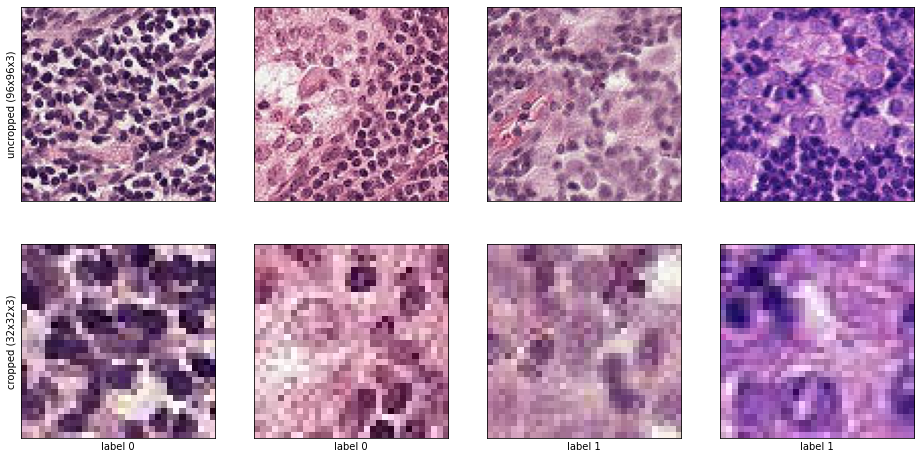

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)

def show(imgs):
    fig, axs = plt.subplots(nrows=2, ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img_raw = Image.open(os.path.join(TRAIN_DIR, img[0]))
        img_cropped = Image.open(os.path.join(TRAIN_CROPPED_DIR, img[0]))
        axs[0, i].imshow(np.asarray(img_raw))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[1, i].imshow(np.asarray(img_cropped))
        axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[1, i].set_xlabel(f'label {img[1]}')
    axs[0, 0].set_ylabel('uncropped (96x96x3)')
    axs[1, 0].set_ylabel('cropped (32x32x3)')

imgs = []
csv_0 = pd.read_csv(CSV_PATH_0)
csv_1 = pd.read_csv(CSV_PATH_1)
for _ in range(2):
    row = csv_0.loc[random.randint(0,len(csv_0)-1),:]
    imgs.append((row['imageFileName'], row['label']))
for _ in range(2):
    row = csv_1.loc[random.randint(0,len(csv_1)-1),:]
    imgs.append((row['imageFileName'], row['label']))
show(imgs)

As shown above, the left 2 columns are label-0 images, and the right 2 columns are label-1 images. It is nearly impossible for a human being to tell the difference.

Therefore, we will use machine learning models for this task.

# Model Walkthrough

The following walkthrough is for the CNN model in our report for Step 3 (i.e. 5% of the raw dataset).

Please note that this code was a re-run version of the original code, as we each did our own part individually and locally. This re-run version is executed on colab with the addition of loss plots and data exploration.

### Data Processing

Import necessary packages and define necessary constants here for Model Walkthrough

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from PIL import Image
from tqdm import tqdm

# Paths
# The CSV files map each image filename to its corresponding label
# CSV_PATH_0 specifies the image filenames with label==0 of the training data for Step 3
CSV_PATH_0 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class0_5.csv'
# CSV_PATH_1 specifies the image filenames with label==1 of the training data for Step 3
CSV_PATH_1 = '/content/gdrive/Shareddrives/CIS520/dataSupersets/trainDev_ImagesAndLabels_class1_5.csv'
# TEST_CSV_PATH specifies the image filenames of the test data, which consists of 20000 unknown examples
TEST_CSV_PATH = '/content/gdrive/Shareddrives/CIS520/dataSupersets/test_ImagesAndLabels.csv'
# FOLDER_PATH specifies the path to the folder of all cropped images.
FOLDER_PATH = '/content/train_cropped/'

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(8888)

# Hyperparameters
BATCH_SIZE = 4
N_EPOCHS = 10

Create Torch Dataset classes

In [ ]:
class TrainSet(Dataset):
    def __init__(self, df, img_dir, transform):
        """
        Initializes the TrainSet
        Args:
            df: a dataframe object which contains image filenames and their corresponding labels
            img_dir: a string of the path to the image folder
            transform: a transforms object which transforms the images
        """
        self.csv = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.csv)

    def __getitem__(self, i):
        """
        Returns a sample of image and its corresponding label
        """
        return {'image': self.transform(Image.open(os.path.join(self.img_dir, self.csv.loc[i,'imageFileName']))),
                'label': torch.tensor(int(self.csv.loc[i,'label']))}

In [ ]:
# This is similar to TrainSet except that there is no label, so I will not annotate this part.
class TestSet(Dataset):
    def __init__(self, df, img_dir, transform):
        self.csv = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.csv)

    def __getitem__(self, i):
        return {'image': self.transform(Image.open(os.path.join(self.img_dir, self.csv.loc[i,'imageFileName'])))}

Concatenate and Shuffle CSV for label 0 and CSV for label 1 as one aggregate DataFrame

In [ ]:
filelist_df = pd.concat([pd.read_csv(CSV_PATH_0), pd.read_csv(CSV_PATH_1)], axis=0).sample(frac=1).reset_index(drop=True)

Train_val split with ratio 0.8:0.2. Read test csv as well.

In [ ]:
train_df = filelist_df.loc[:int(len(filelist_df)*0.8),:].reset_index(drop=True)
val_df =   filelist_df.loc[int(len(filelist_df)*0.8):,:].reset_index(drop=True)
test_df =  pd.read_csv(TEST_CSV_PATH)[:20000]

Initialize transform, datasets, and dataloaders

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = {
    'train': TrainSet(df=train_df, img_dir=FOLDER_PATH, transform=img_transform),
    'val':   TrainSet(df=val_df,   img_dir=FOLDER_PATH, transform=img_transform),
    'test':  TestSet( df=test_df,  img_dir=FOLDER_PATH, transform=img_transform)
}

dataloader = {
    'train': DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val':   DataLoader(dataset['val'],   batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'test':  DataLoader(dataset['test'],  batch_size=BATCH_SIZE)
}

### CNN

Initialize model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # The hyperparameters here are selected through manual tuning based on validation accuracy
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = CNN().to(DEVICE)

Initialize optimizer and loss

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Initialize training process

In [ ]:
def train(model, dataset=dataset, dataloader=dataloader, criterion=criterion, optimizer=optimizer, n_epochs=N_EPOCHS):
    # initialize caches for average train/val loss/acc and epoch train/val loss/acc
    d_loss = {
        "train":[],
        "val":[]
    }
    d_acc = {
        "train":[],
        "val":[]
    }
    d_epoch_loss = {
        "train":[],
        "val":[]
    }
    d_epoch_acc = {
        "train":[],
        "val":[]
    }

    # train
    for epoch in range(n_epochs):
        # print logs
        start = time.time()
        print('Epoch {}/{}'.format(epoch+1, n_epochs))
        print('-' * 10)

        # train first and validation after
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
    
            running_loss = 0.0
            running_corrects = 0

            for i,d in enumerate(tqdm(dataloader[phase])):
                # compute loss
                inputs, labels = d['image'].to(DEVICE), d['label'].to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # optimize if we are in 'train' mode
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
                # record average loss/acc in cache
                if i % 200 == 199:
                    d_loss[phase].append(running_loss/(i*BATCH_SIZE))
                    d_acc[phase].append(running_corrects/(i*BATCH_SIZE))

            # record epoch loss/acc in cache
            epoch_loss = running_loss/len(dataset[phase])
            epoch_acc = running_corrects.double()/len(dataset[phase])
            d_epoch_loss[phase].append(epoch_loss)
            d_epoch_acc[phase].append(epoch_acc)
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # print time for training/validation
        end = time.time()
        print(f'Time: {end-start}')

    # return model and the caches for train/val curves
    return model, d_loss, d_acc, d_epoch_loss, d_epoch_acc

Train

In [ ]:
model, d_loss, d_acc, d_epoch_loss, d_epoch_acc = train(model)

Epoch 1/10
----------


100%|██████████| 2098/2098 [00:17<00:00, 121.20it/s]


train loss: 0.6928, acc: 0.5103


100%|██████████| 525/525 [00:03<00:00, 168.52it/s]


val loss: 0.6906, acc: 0.5148
Time: 20.453564882278442
Epoch 2/10
----------


100%|██████████| 2098/2098 [00:17<00:00, 122.86it/s]


train loss: 0.6788, acc: 0.5618


100%|██████████| 525/525 [00:03<00:00, 166.35it/s]


val loss: 0.6466, acc: 0.6554
Time: 20.259678602218628
Epoch 3/10
----------


100%|██████████| 2098/2098 [00:17<00:00, 119.52it/s]


train loss: 0.6372, acc: 0.6410


100%|██████████| 525/525 [00:04<00:00, 107.00it/s]


val loss: 0.5645, acc: 0.7345
Time: 22.491021871566772
Epoch 4/10
----------


100%|██████████| 2098/2098 [00:21<00:00, 98.32it/s] 


train loss: 0.5767, acc: 0.7071


100%|██████████| 525/525 [00:03<00:00, 138.97it/s]


val loss: 0.5481, acc: 0.7369
Time: 25.1515154838562
Epoch 5/10
----------


100%|██████████| 2098/2098 [00:28<00:00, 74.31it/s]


train loss: 0.5524, acc: 0.7290


100%|██████████| 525/525 [00:06<00:00, 81.55it/s] 


val loss: 0.5813, acc: 0.7011
Time: 34.70763325691223
Epoch 6/10
----------


100%|██████████| 2098/2098 [00:20<00:00, 100.20it/s]


train loss: 0.5379, acc: 0.7358


100%|██████████| 525/525 [00:04<00:00, 128.75it/s]


val loss: 0.5255, acc: 0.7526
Time: 25.03958535194397
Epoch 7/10
----------


100%|██████████| 2098/2098 [00:17<00:00, 122.59it/s]


train loss: 0.5345, acc: 0.7432


100%|██████████| 525/525 [00:03<00:00, 163.84it/s]


val loss: 0.5581, acc: 0.7255
Time: 20.345410585403442
Epoch 8/10
----------


100%|██████████| 2098/2098 [00:16<00:00, 124.77it/s]


train loss: 0.5327, acc: 0.7463


100%|██████████| 525/525 [00:03<00:00, 164.93it/s]


val loss: 0.5191, acc: 0.7602
Time: 20.01266598701477
Epoch 9/10
----------


100%|██████████| 2098/2098 [00:16<00:00, 124.20it/s]


train loss: 0.5237, acc: 0.7480


100%|██████████| 525/525 [00:03<00:00, 169.89it/s]


val loss: 0.5222, acc: 0.7479
Time: 20.003890991210938
Epoch 10/10
----------


100%|██████████| 2098/2098 [00:16<00:00, 125.00it/s]


train loss: 0.5175, acc: 0.7546


100%|██████████| 525/525 [00:03<00:00, 169.41it/s]

val loss: 0.5388, acc: 0.7450
Time: 19.903894186019897


Plot the average train/validation loss/accuracy plots

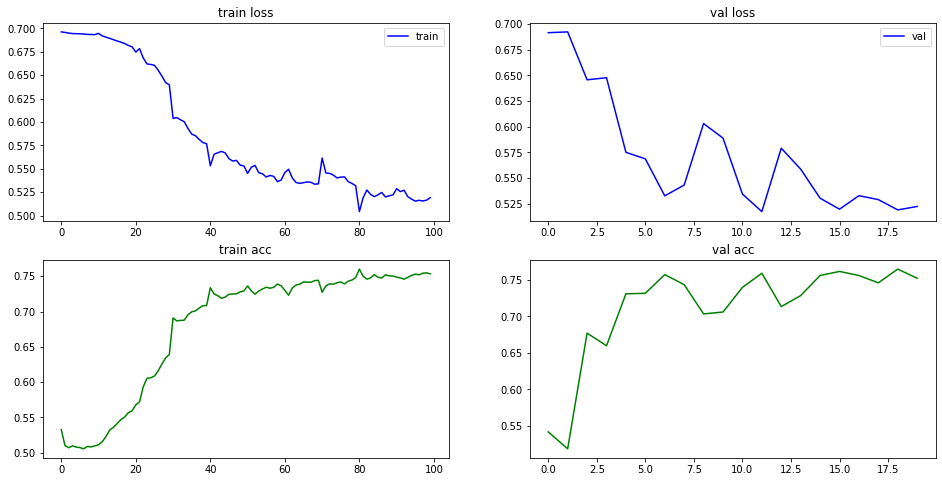

In [ ]:
fig = plt.figure()
ax0 = fig.add_subplot(221, title="train loss")
ax1 = fig.add_subplot(222, title="val loss")
ax2 = fig.add_subplot(223, title="train acc")
ax3 = fig.add_subplot(224, title="val acc")
ax0.plot(range(len(d_loss['train'])), d_loss['train'], 'b', label='train')
ax1.plot(range(len(d_loss['val'])), d_loss['val'], 'b', label='val')
ax2.plot(range(len(d_acc['train'])), d_acc['train'], 'g', label='train')
ax3.plot(range(len(d_acc['val'])), d_acc['val'], 'g', label='val')
# if current_epoch == 0:
ax0.legend()
ax1.legend()
plt.show()

Plot the per-epoch train/validation loss/accuracy plots

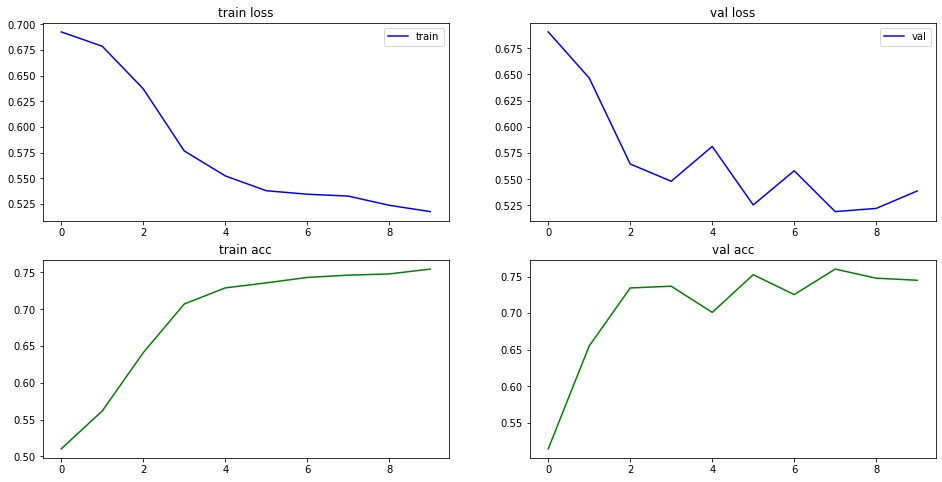

In [ ]:
fig = plt.figure()
ax0 = fig.add_subplot(221, title="train loss")
ax1 = fig.add_subplot(222, title="val loss")
ax2 = fig.add_subplot(223, title="train acc")
ax3 = fig.add_subplot(224, title="val acc")
ax0.plot(range(len(d_epoch_loss['train'])), d_epoch_loss['train'], 'b', label='train')
ax1.plot(range(len(d_epoch_loss['val'])), d_epoch_loss['val'], 'b', label='val')
ax2.plot(range(len(d_epoch_acc['train'])), d_epoch_acc['train'], 'g', label='train')
ax3.plot(range(len(d_epoch_acc['val'])), d_epoch_acc['val'], 'g', label='val')
# if current_epoch == 0:
ax0.legend()
ax1.legend()
plt.show()

Test

In [ ]:
def test(model, y=test_df['label'].to_numpy(), dataset=dataset, dataloader=dataloader, criterion=criterion):
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in tqdm(dataloader['test']):
            probs.append(nn.Softmax(dim=1)(model(batch["image"].to(DEVICE))))
    y_pred = torch.cat(probs, dim=0).argmax(dim=1).cpu().data.numpy()
    y_score = torch.cat(probs, dim=0)[:,1]
    return y_pred, y_score

In [ ]:
y_pred, y_score = test(model)

100%|██████████| 5000/5000 [00:16<00:00, 296.98it/s]


In [ ]:
y = test_df['label'].to_numpy()

Print test accuracy

In [ ]:
acc = accuracy_score(y, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.7196


Plot confusion matrix

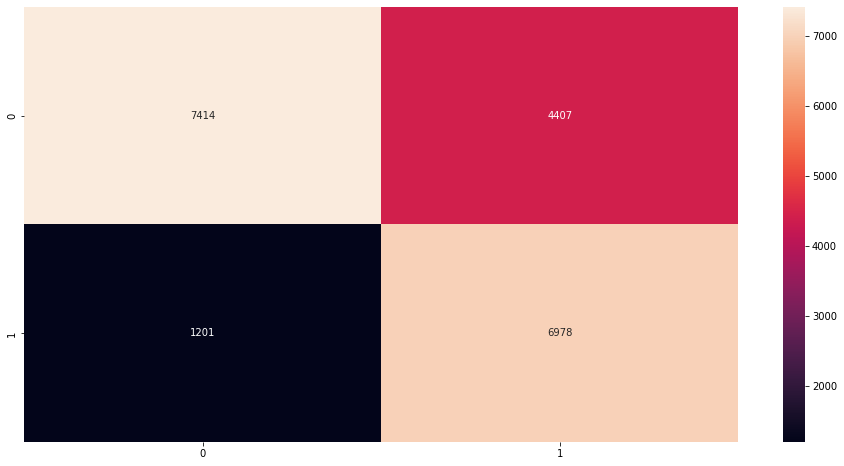

In [ ]:
mat = confusion_matrix(y, y_pred)
sns.heatmap(mat, annot=True, fmt='g')

Print classification report

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.63      0.73     11821
           1       0.61      0.85      0.71      8179

    accuracy                           0.72     20000
   macro avg       0.74      0.74      0.72     20000
weighted avg       0.76      0.72      0.72     20000



Plot ROC & Print AUC

AUC:  0.8316329082055898


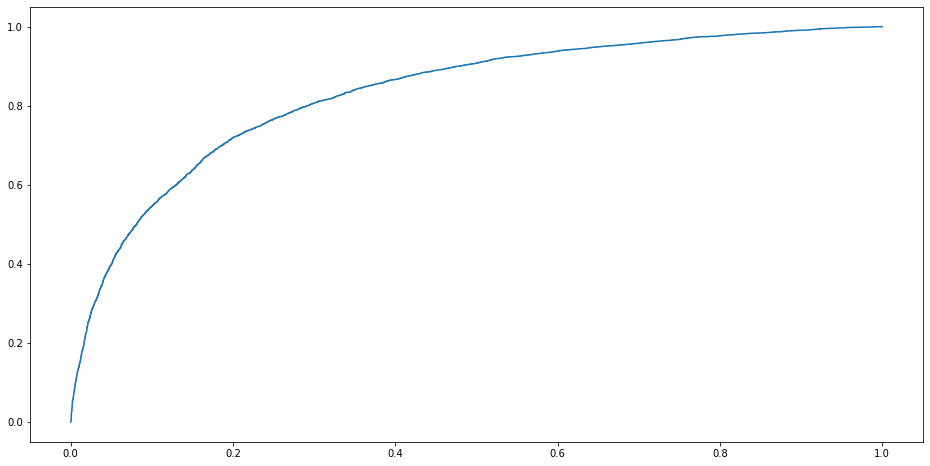

In [ ]:
fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)
print("AUC: ", auc(fpr, tpr))
plt.plot(fpr, tpr)